2025-04-11 21:41:01,930 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best:   3%|▎         |1/30, best_cost=-0.903C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
pyswarms.single.global_best:   7%|▋         |2/30, best_cost=-0.903C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: overflow encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: invalid value encountered in matmul
  ret =

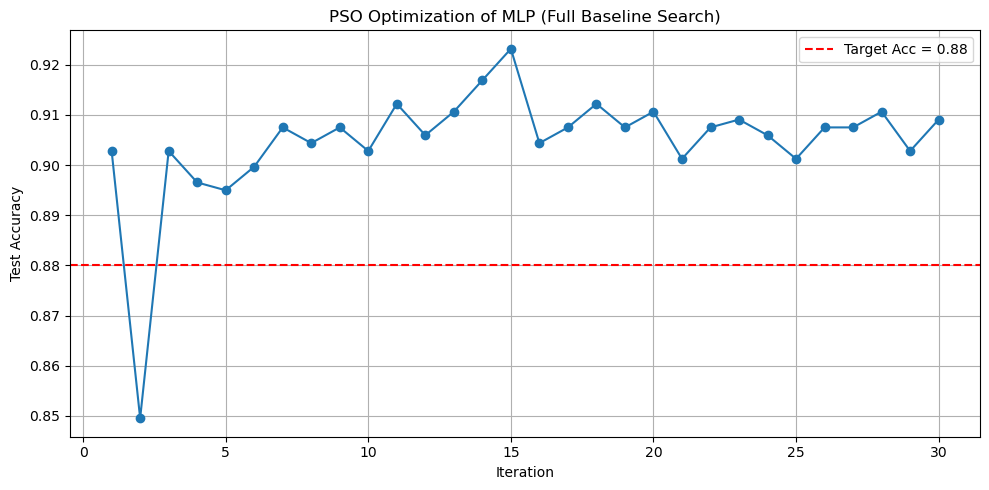

{'Best Test Accuracy': 0.9231974921630094,
 'Best Hidden Layer Size': (61,),
 'Best Learning Rate Init': 0.7560239143691759,
 'Best Alpha': 0.6197360043477245,
 'Best Activation': 'logistic',
 'Best Solver': 'lbfgs',
 'Total Attempts': 450,
 'Search Dimensions': 5,
 'Wall Time (s)': 513.25,
 'Convergence Round (≥ 0.880)': 1}

In [3]:
# MLP + PSO (no parameter constraints), full search baseline, record all key metrics
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from pyswarms.single import GlobalBestPSO
from ucimlrepo import fetch_ucirepo

# Silence convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and preprocess dataset
dataset = fetch_ucirepo(id=69)  # Gene splicing dataset
X_raw = dataset.data.features
y_raw = dataset.data.targets
X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define wide search space for MLP hyperparameters
# [hidden_layer_size, learning_rate_init, alpha, activation, solver]
activation_options = ['identity', 'logistic', 'tanh', 'relu']
solver_options = ['lbfgs', 'sgd', 'adam']
lb = [5, 1e-4, 1e-6, 0, 0]         # hidden size, lr_init, alpha, act idx, solver idx
ub = [200, 1.0, 1.0, 3, 2]
bounds = (np.array(lb), np.array(ub))

# Accuracy and cost tracking
accuracy_history = []
start_time = time.time()
target_acc = 0.88
convergence_round = None

# Objective function (no CV)
def objective_mlp(swarm):
    results = []
    global convergence_round
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]

            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)

        except:
            results.append(1.0)

    best_score = -min(results)
    accuracy_history.append(best_score)
    if best_score >= target_acc and convergence_round is None:
        convergence_round = len(accuracy_history)
    return np.array(results)

# Run PSO (baseline, wide config)
n_particles = 15
max_iter = 30
optimizer = GlobalBestPSO(
    n_particles=n_particles,
    dimensions=5,
    options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
    bounds=bounds
)
cost, best_pos = optimizer.optimize(objective_mlp, iters=max_iter)
end_time = time.time()

# Decode best params
best_hidden = (int(round(best_pos[0])),)
best_lr = float(best_pos[1])
best_alpha = float(best_pos[2])
best_activation = activation_options[int(round(best_pos[3]))]
best_solver = solver_options[int(round(best_pos[4]))]

# Final model
model = MLPClassifier(
    hidden_layer_sizes=best_hidden,
    learning_rate_init=best_lr,
    alpha=best_alpha,
    activation=best_activation,
    solver=best_solver,
    max_iter=500,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history)+1), accuracy_history, marker='o')
plt.axhline(y=target_acc, color='r', linestyle='--', label=f'Target Acc = {target_acc}')
plt.title("PSO Optimization of MLP (Full Baseline Search)")
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Output metrics summary
metrics = {
    'Best Test Accuracy': final_accuracy,
    'Best Hidden Layer Size': best_hidden,
    'Best Learning Rate Init': best_lr,
    'Best Alpha': best_alpha,
    'Best Activation': best_activation,
    'Best Solver': best_solver,
    'Total Attempts': n_particles * max_iter,
    'Search Dimensions': 5,
    'Wall Time (s)': round(end_time - start_time, 2),
    'Convergence Round (≥ {:.3f})'.format(target_acc): convergence_round
}
metrics


2025-04-11 21:52:23,805 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/30C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
pyswarms.single.global_best:  13%|█▎        |4/30, best_cost=-0.917C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: overflow encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max

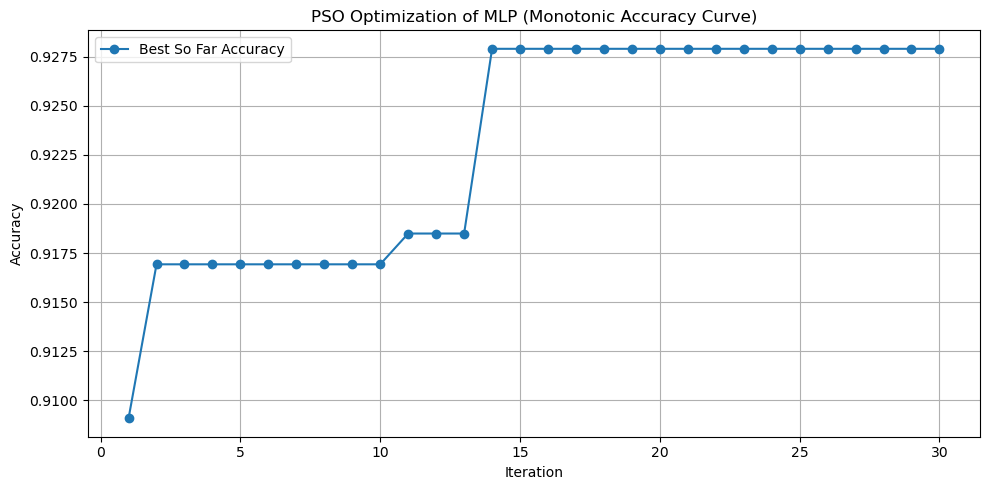

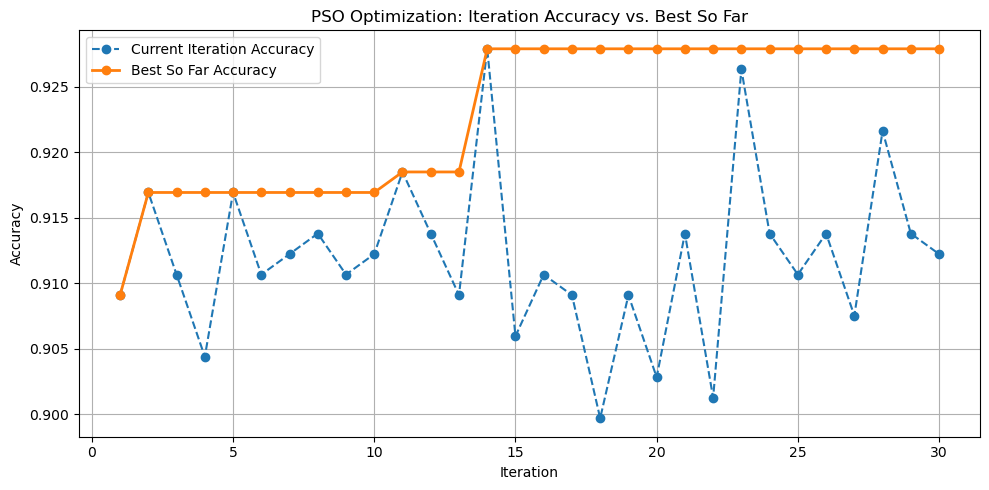


=== Per-Iteration Accuracy Log ===
    Iteration  Current_Accuracy  Best_So_Far_Accuracy
0           1            0.9091                0.9091
1           2            0.9169                0.9169
2           3            0.9107                0.9169
3           4            0.9044                0.9169
4           5            0.9169                0.9169
5           6            0.9107                0.9169
6           7            0.9122                0.9169
7           8            0.9138                0.9169
8           9            0.9107                0.9169
9          10            0.9122                0.9169
10         11            0.9185                0.9185
11         12            0.9138                0.9185
12         13            0.9091                0.9185
13         14            0.9279                0.9279
14         15            0.9060                0.9279
15         16            0.9107                0.9279
16         17            0.9091               

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from pyswarms.single import GlobalBestPSO
from ucimlrepo import fetch_ucirepo

# Silence convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load and preprocess dataset
dataset = fetch_ucirepo(id=69)  # Gene splicing dataset
X_raw = dataset.data.features
y_raw = dataset.data.targets
X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define wide search space for MLP hyperparameters
activation_options = ['identity', 'logistic', 'tanh', 'relu']
solver_options = ['lbfgs', 'sgd', 'adam']
lb = [5, 1e-4, 1e-6, 0, 0]
ub = [200, 1.0, 1.0, 3, 2]
bounds = (np.array(lb), np.array(ub))

# Accuracy tracking
accuracy_history = []
best_so_far_history = []

# Objective function
def objective_mlp(swarm):
    results = []
    global accuracy_history, best_so_far_history
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]

            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)

        except:
            results.append(1.0)

    best_acc = -min(results)
    accuracy_history.append(best_acc)
    if best_so_far_history:
        best_so_far_history.append(max(best_acc, best_so_far_history[-1]))
    else:
        best_so_far_history.append(best_acc)

    return np.array(results)

# Run PSO
start_time = time.time()
n_particles = 15
max_iter = 30
optimizer = GlobalBestPSO(
    n_particles=n_particles,
    dimensions=5,
    options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
    bounds=bounds
)
cost, best_pos = optimizer.optimize(objective_mlp, iters=max_iter)
end_time = time.time()

# Decode best parameters
best_hidden = (int(round(best_pos[0])),)
best_lr = round(float(best_pos[1]), 4)
best_alpha = round(float(best_pos[2]), 4)
best_activation = activation_options[int(round(best_pos[3]))]
best_solver = solver_options[int(round(best_pos[4]))]

# Final model
model = MLPClassifier(
    hidden_layer_sizes=best_hidden,
    learning_rate_init=best_lr,
    alpha=best_alpha,
    activation=best_activation,
    solver=best_solver,
    max_iter=500,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
final_accuracy = round(accuracy_score(y_test, y_pred), 4)

# Plot 1: monotonic best accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(best_so_far_history)+1), best_so_far_history, marker='o', label="Best So Far Accuracy")
plt.title("PSO Optimization of MLP (Monotonic Accuracy Curve)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: current vs. best so far
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history)+1), accuracy_history, marker='o', linestyle='--', label="Current Iteration Accuracy")
plt.plot(range(1, len(best_so_far_history)+1), best_so_far_history, marker='o', label="Best So Far Accuracy", linewidth=2)
plt.title("PSO Optimization: Iteration Accuracy vs. Best So Far")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy per iteration summary
iteration_data = pd.DataFrame({
    'Iteration': list(range(1, len(accuracy_history) + 1)),
    'Current_Accuracy': accuracy_history,
    'Best_So_Far_Accuracy': best_so_far_history
}).round(4)

print("\n=== Per-Iteration Accuracy Log ===")
print(iteration_data)

# Output summary
metrics = {
    'Best Test Accuracy': final_accuracy,
    'Best Hidden Layer Size': best_hidden,
    'Best Learning Rate Init': best_lr,
    'Best Alpha': best_alpha,
    'Best Activation': best_activation,
    'Best Solver': best_solver,
    'Total Attempts': n_particles * max_iter,
    'Search Dimensions': 5,
    'Wall Time (s)': round(end_time - start_time, 2)
}
print("\n=== PSO + MLP Optimization Summary ===")
for k, v in metrics.items():
    print(f"{k}: {v}")
